In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
# set version
version = 2
full = False

# load metrics
if full:
    metrics = pd.read_csv("lightning_logs/nc_128/metrics.csv")
else:
    metrics = pd.read_csv(f"lightning_logs/version_{version}/metrics.csv")

# merge entries on the same step
metrics = metrics.groupby("step").first()
metrics

,epoch,nc_layer_0,nc_layer_1,nc_output,train_acc,train_loss
step,,,,,,
0,0,NaN,NaN,NaN,0.129167,9.760267
1,0,NaN,NaN,NaN,0.162500,6.432711
2,0,NaN,NaN,NaN,0.233333,6.234537
3,0,NaN,NaN,NaN,0.308333,4.167599
4,0,NaN,NaN,NaN,0.312500,3.433640
...,...,...,...,...,...,...
1245,4,NaN,NaN,NaN,0.995833,0.005603
1246,4,NaN,NaN,NaN,1.000000,0.002844
1247,4,NaN,NaN,NaN,1.000000,0.001570


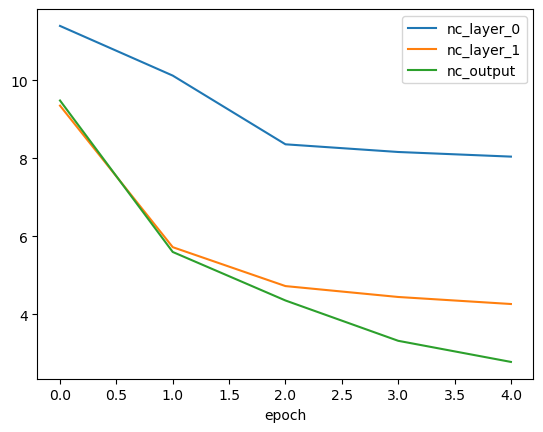

In [26]:
no_nan = metrics.dropna()

# plot NC1
nc_cols = no_nan.columns[no_nan.columns.str.contains("nc_")]
no_nan.plot(x="epoch", y=nc_cols)
plt.show()

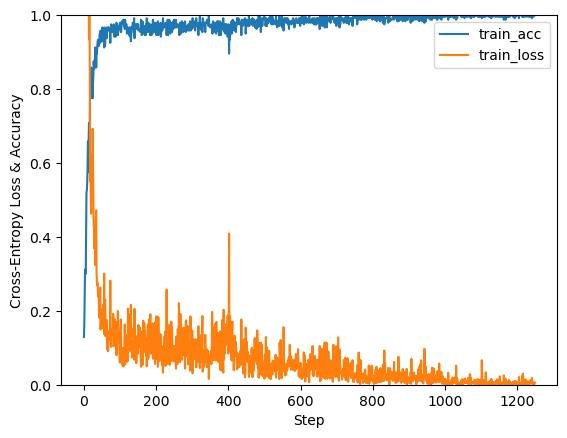

In [27]:
# plot train loss
train_col = metrics.columns[metrics.columns.str.contains("train_")]
metrics.plot(y=train_col, use_index=True)
plt.ylim(0,1)
plt.xlabel("Step")
plt.ylabel("Cross-Entropy Loss & Accuracy")
plt.legend()
plt.show()

0.6423632502555847


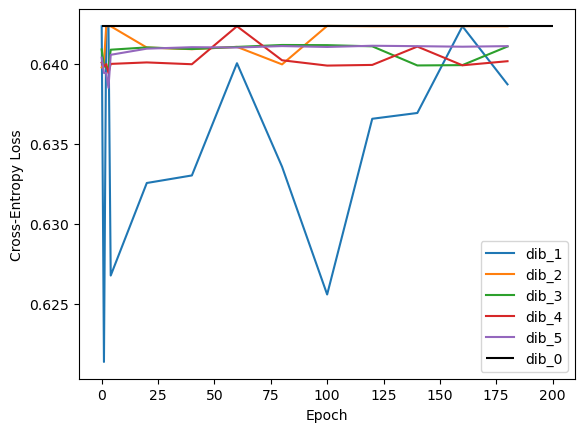

In [ ]:
# remove NaN rows
no_nan = metrics.dropna()
dib_0 = no_nan["dib_0"].iloc[0]

no_nan = metrics.drop(columns="dib_0").dropna()

# plot DIB
dib_cols = no_nan.columns[no_nan.columns.str.contains("dib_")]
no_nan.plot(x="epoch", y=dib_cols)
plt.hlines(dib_0, 0, metrics.shape[0], color="black", label="dib_0")
# plt.xlim(0,150)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()

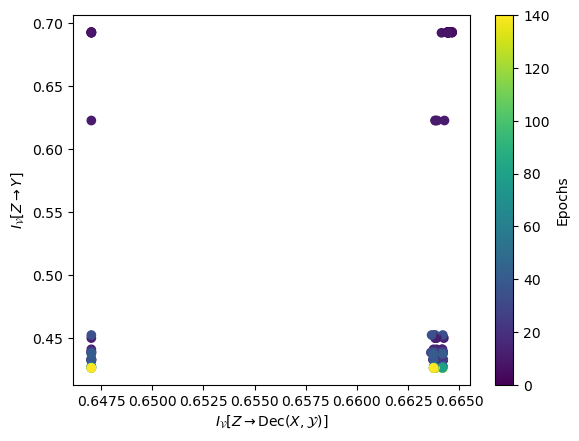

In [10]:
# IP analysis
for dib in dib_cols:
    plt.scatter(metrics[dib], metrics["train_loss"], cmap="viridis", c=metrics["epoch"])
    plt.plot(metrics[dib], metrics["train_loss"], color="gray", linewidth=0.5)
plt.xlabel(r"$I_{\mathcal{V}}[Z \to \operatorname{Dec}(X,\mathcal{Y})]$")
plt.ylabel(r"$I_{\mathcal{V}}[Z \to Y]$")
plt.colorbar(label="Epochs")
plt.show()